## Multi Class Classification

- Binary classification -> One thing or another (cat vs dog, spam vs not spam, fraud vs non fraud)
- multiclass -> More than one or another (cat vs dog vs chiken)

### In this we use
1. Output Activation function -> softmax(`torch.softmax`)
2. Loss function -> Cross entropy (`torch.nn.CrossEntropyLoss`)

### Creating a toy multiclass dataset

In [1]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=5,
                            cluster_std = 1.3,
                            random_state = 10)

In [3]:
# turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

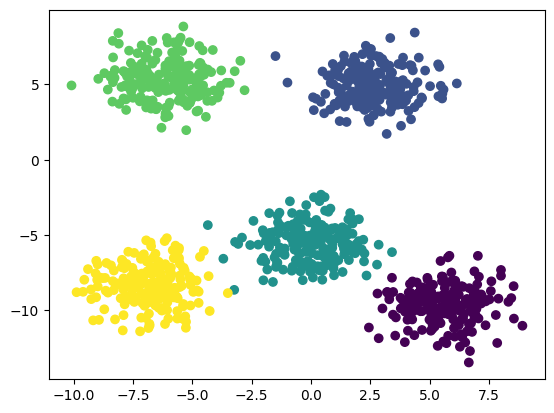

In [4]:
# lets visualize the above data
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=10)

In [6]:
# lets create the device agnostic code
device = "cuda" if torch.cuda.is_available() else"cpu"
device

'cuda'

In [7]:
# lets build a NN

class MultiClassNN(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MultiClassNN(input_features=2,
                     output_features=5,
                     hidden_units=8).to(device)

model

MultiClassNN(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [8]:
# lets create loss function and optimizer
loss_fc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                         lr= 0.1)

In [9]:
# geting prediction probabilty
model(X_train.to(device))[:5]

tensor([[ 0.4948,  0.8328, -0.1435,  0.9358,  0.1304],
        [-0.1683, -0.3728, -0.6187,  0.4127,  0.3376],
        [ 0.3200,  0.1715, -0.1728,  0.4292, -0.1486],
        [-0.1663, -0.2717, -0.6255,  0.4762,  0.4001],
        [ 0.2349, -0.0148, -0.2551,  0.3498, -0.1111]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [10]:
model(X_train.to(device))[0].shape, len(y_train.unique())

(torch.Size([5]), 5)

- As in, how do we go from `logits -> prediction probabilities -> prediction labels` just like we did with the binary classification problem?

- That's where the ***softmax activation function** comes into play.

In [11]:
y_logits = model(X_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2103, -0.0354, -0.2611,  0.3385, -0.0817],
        [-0.1094, -0.1345, -0.6593,  0.6263,  0.5355],
        [-0.1050, -0.3971, -0.5139,  0.3177,  0.2361],
        [-0.1613, -0.3968, -0.5687,  0.4073,  0.3302],
        [ 0.4558,  0.2884, -0.1082,  0.4620, -0.3067]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2331, 0.1823, 0.1455, 0.2650, 0.1741],
        [0.1528, 0.1490, 0.0882, 0.3189, 0.2912],
        [0.1871, 0.1397, 0.1243, 0.2856, 0.2632],
        [0.1708, 0.1349, 0.1136, 0.3015, 0.2791],
        [0.2572, 0.2176, 0.1463, 0.2588, 0.1200]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [12]:
torch.sum(y_pred_probs[:5][0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [13]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2331, 0.1823, 0.1455, 0.2650, 0.1741], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [14]:
# lets check for index 1
print(y_pred_probs[1])
print(torch.argmax(y_pred_probs[1]))

tensor([0.1528, 0.1490, 0.0882, 0.3189, 0.2912], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fc(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### Creating a training and testing loop for a multi-class PyTorch model

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):

  # traning
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate loss and accuracy
  loss = loss_fc(y_logits, y_train)
  accuracy = accuracy_fc(y_true = y_train,
                         y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing mode

  model.eval()
  with torch.inference_mode():

    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fc(test_logits, y_test)
    test_acc = accuracy_fc(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.55691, Acc: 17.25% | Test Loss: 1.17827, Test Acc: 42.00%
Epoch: 10 | Loss: 0.09607, Acc: 95.62% | Test Loss: 0.05869, Test Acc: 98.00%
Epoch: 20 | Loss: 0.08244, Acc: 97.50% | Test Loss: 0.10251, Test Acc: 95.50%
Epoch: 30 | Loss: 0.05794, Acc: 98.38% | Test Loss: 0.02022, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04009, Acc: 98.88% | Test Loss: 0.02442, Test Acc: 99.00%
Epoch: 50 | Loss: 0.01981, Acc: 99.25% | Test Loss: 0.03205, Test Acc: 99.50%
Epoch: 60 | Loss: 0.01586, Acc: 99.62% | Test Loss: 0.01924, Test Acc: 99.50%
Epoch: 70 | Loss: 0.01105, Acc: 99.62% | Test Loss: 0.01193, Test Acc: 99.50%
Epoch: 80 | Loss: 0.00806, Acc: 100.00% | Test Loss: 0.01236, Test Acc: 99.50%
Epoch: 90 | Loss: 0.00594, Acc: 100.00% | Test Loss: 0.01272, Test Acc: 99.50%


#### Making and evaluating predictions with a PyTorch multi-class model

In [17]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-30.3721,  32.6402, -10.0079,   1.5734, -28.9909],
        [-59.5840, -28.3335,  17.1095,   7.4271,  29.1424],
        [ -4.7621, -13.6436,  14.2133, -17.1377,   4.1592],
        [ 23.8046, -22.0275,  14.5856, -30.3091,  -7.2973],
        [-44.5079,  50.3208, -17.4917,   2.7060, -45.3329],
        [-48.0542, -27.8547,  17.8169,   0.5307,  26.9275],
        [ -8.2776, -11.7653,  13.3235, -14.8879,   5.0247],
        [ 22.3442, -20.2621,  13.3511, -27.8836,  -7.0260],
        [ 24.6354, -22.3780,  14.5496, -30.6410,  -7.5301],
        [-29.2195,  34.4905, -11.9330,   1.3957, -32.4026]], device='cuda:0')

In [18]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fc(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([1, 4, 2, 0, 1, 4, 2, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 4, 2, 0, 1, 4, 2, 0, 0, 1], device='cuda:0')
Test accuracy: 99.5%


In [19]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [20]:
# import numpy as np
# # Convert `X_train` and `y_train` to NumPy arrays if they are tensors
# X_train_np = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
# y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train

# X_test_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
# y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


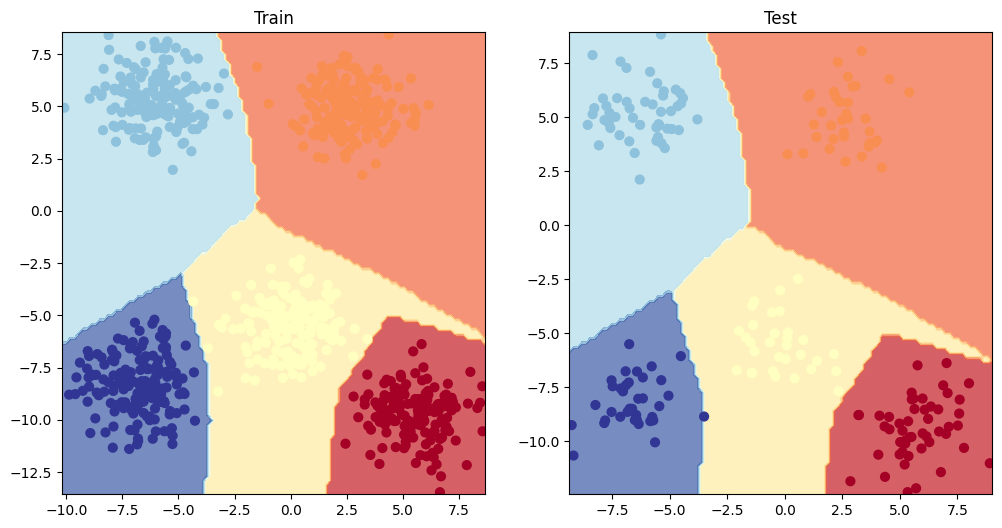

In [21]:
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

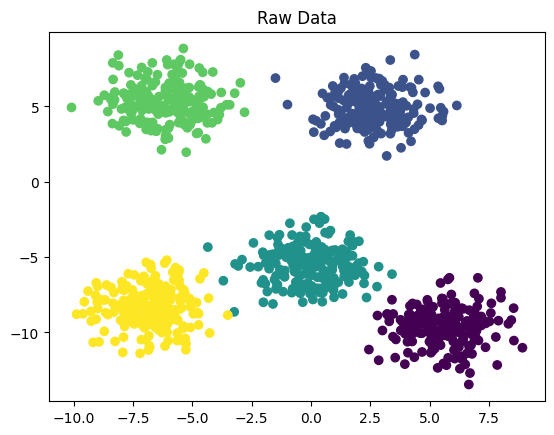

In [22]:
plt.title("Raw Data")
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob)
plt.show()